In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tarfile
import kagglehub
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import gensim
from gensim import corpora
from gensim.models import LdaModel

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Import Class Data

In [4]:

#import class corpus data
folder_path = 'C:/Users/patri/MSDS 453/Reviews'  # adjust this as needed

review_data = []

#as several files, run a loop and import them into a list
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        filepath = os.path.join(folder_path, filename)
        with open(filepath, 'r', encoding='utf-8', errors="ignore") as f:
            text = f.read()
        
        # Parse filename: e.g., 'critic_oppenheimer_01.txt'
        parts = filename.replace('.txt', '').split('_')
        if len(parts) >= 2:
            author_type = parts[0]
            no = parts[1]
        else:
            author_type = 'unknown'
            movie = 'unknown'
        
        #add relevant headers from file name
        review_data.append({
            'text': text,
            'author': author_type,
            'doc_no': no,
            'filename': filename
        })

#convert list to df
df = pd.DataFrame(review_data)
df.head(10)

,text,author,doc_no,filename
0,Title: [Elvis drowns Austin Butlers spot-on pe...,ERR,Doc1,ERR_Doc1_Elvis-drowns-Austin.txt
1,"Title: [Elvis review blistering, turbocharged...",ERR,Doc2,ERR_Doc2_Elvis-review-blistering.txt
2,"Title: [In 'Elvis,' an icon remains an icon, a...",ERR,Doc3,ERR_Doc3_In-Elvis-an.txt
3,“The Grand Budapest Hotel” is conveyed not jus...,JJ,Doc1,JJ_Doc1_Grand_Budapest_Hotel.txt
4,The game but losing battle waged by Old World ...,JJ,Doc2,JJ_Doc2_Grand_Budapest_Hotel.txt
5,A transfixing chord of melancholy runs through...,JJ,Doc3,JJ_Doc3_Grand_Budapest_Hotel.txt
6,* Title:[Thunderbolts Review: The Best Marvel ...,KK,Doc1,KK_Doc1_Thunderbolts.txt
7,"* Title:[Thunderbolts is an unwieldly jumble, ...",KK,Doc2,KK_Doc2_Thunderbolts.txt
8,"* Title:[Thunderbolts]\n* Authors:[Tallerico, ...",KK,Doc3,KK_Doc3_Thunderbolts.txt
9,With a film whose existence is rooted in fan c...,NJB,Doc1,NJB_Doc1_Star-Wars-Force-Awakens-Consider-me-c...


In [5]:

#import metadata for class corpus
metadata = pd.read_csv('metadata_csv.csv')
#merge into df
df = df.merge(metadata, on='filename', how='left')
#adjust column names. This will be important when 
df_class_data = df[['text', 'movie', 'genre', 'publication','publication_type']]
df_class_data = df_class_data.rename(columns={'text': 'review_text'})
df_class_data = df_class_data.rename(columns={'movie': 'movie_title'})
df_class_data = df_class_data.rename(columns={'publication': 'publisher_name'})

df_class_data.head()

,review_text,movie_title,genre,publisher_name,publication_type
0,Title: [Elvis drowns Austin Butlers spot-on pe...,Elvis,Biopic,CNN,News Media/Journalism
1,"Title: [Elvis review blistering, turbocharged...",Elvis,Biopic,Guardian,News Media/Journalism
2,"Title: [In 'Elvis,' an icon remains an icon, a...",Elvis,Biopic,NPR,News Media/Journalism
3,“The Grand Budapest Hotel” is conveyed not jus...,Grand Budapest Hotel,Comedy,rogerebert.com,Blog
4,The game but losing battle waged by Old World ...,Grand Budapest Hotel,Comedy,Hollywood Reporter,News Media/Journalism


## Import Kaggle Data

In [6]:
#Call Kaggle API - Reviews Dataset
path = kagglehub.dataset_download("stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset")
csv_file_reviews = os.path.join(path, 'rotten_tomatoes_critic_reviews.csv')  # adjust filename if different
df_r = pd.read_csv(csv_file_reviews)
df_r.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [7]:
#Call Kaggle API - Movies Dataset
path = kagglehub.dataset_download("stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset")
csv_file_movies = os.path.join(path, 'rotten_tomatoes_movies.csv')  # adjust filename if different
df_m = pd.read_csv(csv_file_movies)
df_m.head()


,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [8]:
# Merge two kaggle datasets 
df_data = df_r.merge(df_m, on='rotten_tomatoes_link', how='left')
df_data.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,movie_title,movie_info,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43.0,73.0,76.0
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff...",Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43.0,73.0,76.0
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43.0,73.0,76.0
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43.0,73.0,76.0
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43.0,73.0,76.0


In [9]:
#Drop columns that are not relevant to the analysis, and reformat columns so that we can merge with the class corpus
df_data = df_data[['review_content', 'movie_title', 'genres', 'publisher_name']]
metadata_publishers = pd.read_csv("classified_publishers.csv")
df_data = df_data.merge(metadata_publishers, on='publisher_name', how='left')

df_data['genres'] = df_data['genres'].str.split(',').str[0].str.strip()
df_data = df_data.rename(columns={'review_content': 'review_text'})
df_data = df_data.rename(columns={'genres': 'genre'})
df_data = df_data.rename(columns={'category': 'publication_type'})

df_data.head()

,review_text,movie_title,genre,publisher_name,publication_type
0,A fantasy adventure that fuses Greek mythology...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Urban Cinefile,Specialized/Niche
1,"Uma Thurman as Medusa, the gorgon with a coiff...",Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Urban Cinefile,Specialized/Niche
2,With a top-notch cast and dazzling special eff...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,FILMINK (Australia),Entertainment/Trade
3,Whether audiences will get behind The Lightnin...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Sunday Mail (Australia),News Media/Journalism
4,What's really lacking in The Lightning Thief i...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Hollywood Reporter,News Media/Journalism


Merge class and Rotten T data

In [10]:
# Merge class corpus and the Kaggle Dataset
combined_df = pd.concat([df_data, df_class_data], ignore_index=True)

#drop fields with na
df = combined_df.dropna()
df = df.copy()
df.head()

,review_text,movie_title,genre,publisher_name,publication_type
0,A fantasy adventure that fuses Greek mythology...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Urban Cinefile,Specialized/Niche
1,"Uma Thurman as Medusa, the gorgon with a coiff...",Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Urban Cinefile,Specialized/Niche
2,With a top-notch cast and dazzling special eff...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,FILMINK (Australia),Entertainment/Trade
3,Whether audiences will get behind The Lightnin...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Sunday Mail (Australia),News Media/Journalism
4,What's really lacking in The Lightning Thief i...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Hollywood Reporter,News Media/Journalism


## Analysis

### Data Normatlization

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def normalize_text(text):
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# Apply normalization to DataFrame
df['normalized_review'] = df['review_text'].apply(normalize_text)

### Sentiment Analysis

In [15]:
# Use VADER to run sentiment analysis
sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['normalized_review'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Define sentiment category based on compound score
def categorize_sentiment(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# create df column for sentiment category 
df['sentiment_category'] = df['sentiment'].apply(categorize_sentiment)


In [16]:
df.head()

,review_text,movie_title,genre,publisher_name,publication_type,normalized_review,sentiment,sentiment_category
0,A fantasy adventure that fuses Greek mythology...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Urban Cinefile,Specialized/Niche,fantasy adventure fuse greek mythology contemp...,0.7351,positive
1,"Uma Thurman as Medusa, the gorgon with a coiff...",Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Urban Cinefile,Specialized/Niche,uma thurman medusa gorgon coiffure writhing sn...,0.3400,positive
2,With a top-notch cast and dazzling special eff...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,FILMINK (Australia),Entertainment/Trade,topnotch cast dazzling special effect tide tee...,0.4019,positive
3,Whether audiences will get behind The Lightnin...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Sunday Mail (Australia),News Media/Journalism,whether audience get behind lightning thief ha...,0.6249,positive
4,What's really lacking in The Lightning Thief i...,Percy Jackson & the Olympians: The Lightning T...,Action & Adventure,Hollywood Reporter,News Media/Journalism,whats really lacking lightning thief genuine s...,-0.5667,negative


### Summary Statistics

In [17]:
df.describe()

print("DataFrame Info:")
print(df.info())

# Shape of DataFrame
print("\nDataFrame Shape:")
print(df.shape)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Summary stats for numeric columns
print("\nDescriptive Statistics:")
print(df.describe())

# Sentiment category distribution
print("\nSentiment Category Counts:")
print(df['sentiment_category'].value_counts())

# Genre distribution
print("\nGenre Counts:")
print(df['genre'].value_counts())

# Publisher type distribution
print("\nPublication Type Counts:")
print(df['publication_type'].value_counts())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1057311 entries, 0 to 1130034
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   review_text         1057311 non-null  object 
 1   movie_title         1057311 non-null  object 
 2   genre               1057311 non-null  object 
 3   publisher_name      1057311 non-null  object 
 4   publication_type    1057311 non-null  object 
 5   normalized_review   1057311 non-null  object 
 6   sentiment           1057311 non-null  float64
 7   sentiment_category  1057311 non-null  object 
dtypes: float64(1), object(7)
memory usage: 72.6+ MB
None

DataFrame Shape:
(1057311, 8)

Missing Values:
review_text           0
movie_title           0
genre                 0
publisher_name        0
publication_type      0
normalized_review     0
sentiment             0
sentiment_category    0
dtype: int64

Descriptive Statistics:
          sentiment
count  1.05

### LDA Analysis

In [18]:
#take random sample to optimize compute requirements
df_sample = df.sample(n=5000, random_state=42)

#list of tokenized reviews
tokenized_reviews = [review.split() for review in df_sample['normalized_review']]

# Create dictionary and corpus
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

# Build LDA model
lda_model = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary, passes=10)

# Print topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.007*"movie" + 0.005*"film" + 0.005*"like" + 0.005*"get" + 0.005*"feel" + 0.004*"way" + 0.004*"child" + 0.003*"one" + 0.003*"element" + 0.003*"jason"
Topic 1: 0.010*"film" + 0.006*"well" + 0.005*"one" + 0.005*"little" + 0.005*"movie" + 0.004*"front" + 0.004*"like" + 0.004*"isnt" + 0.004*"work" + 0.004*"ridiculous"
Topic 2: 0.012*"film" + 0.009*"movie" + 0.006*"like" + 0.006*"one" + 0.006*"best" + 0.006*"get" + 0.006*"doesnt" + 0.006*"make" + 0.005*"back" + 0.005*"story"
Topic 3: 0.014*"film" + 0.010*"one" + 0.006*"story" + 0.005*"another" + 0.005*"way" + 0.005*"look" + 0.004*"movie" + 0.004*"comedy" + 0.004*"like" + 0.004*"make"
Topic 4: 0.010*"film" + 0.008*"one" + 0.007*"performance" + 0.007*"movie" + 0.005*"character" + 0.005*"scene" + 0.005*"give" + 0.005*"like" + 0.004*"time" + 0.004*"action"
Topic 5: 0.008*"make" + 0.007*"little" + 0.007*"like" + 0.007*"good" + 0.006*"story" + 0.005*"feel" + 0.005*"comedy" + 0.005*"way" + 0.005*"fun" + 0.005*"sequel"
Topic 6: 0.011*"mov

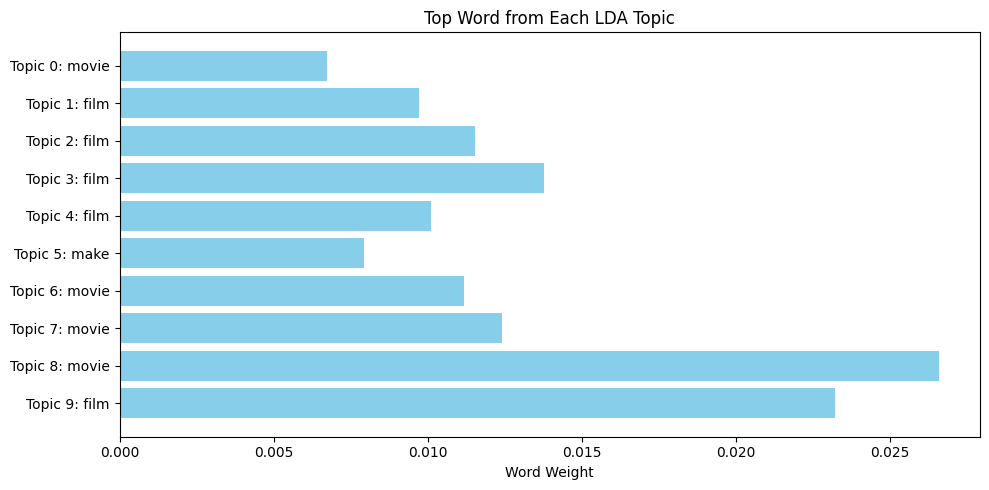

In [20]:
#save topics
topics = lda_model.show_topics(num_topics=10, num_words=1, formatted=False)

topic_labels = []
word_weights = []

#store top words in each topic
for i, topic in topics:
    word, weight = topic[0]
    topic_labels.append(f"Topic {i}: {word}")
    word_weights.append(weight)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(topic_labels, word_weights, color='skyblue')
plt.xlabel("Word Weight")
plt.title("Top Word from Each LDA Topic")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### TF-IDF Analysis

#### TF-IDF Based on Publication Type

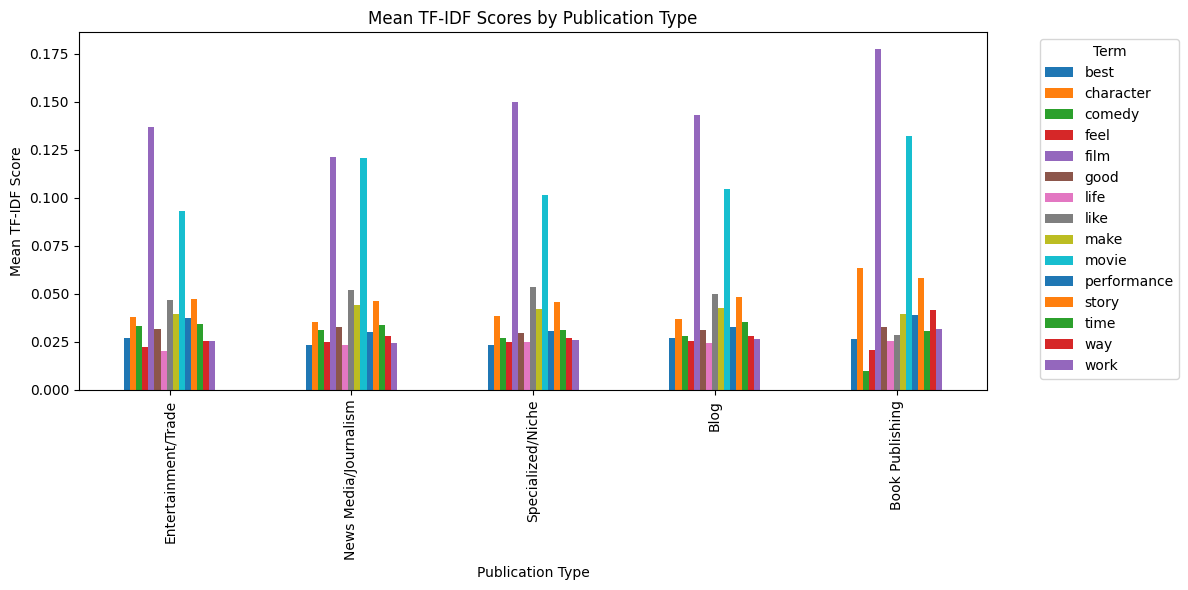

In [40]:
# Filter text by publication type
entertainment_text = df[df['publication_type'] == 'Entertainment/Trade']['normalized_review']
news_text = df[df['publication_type'] == 'News Media/Journalism']['normalized_review']
specialized_text = df[df['publication_type'] == 'Specialized/Niche']['normalized_review']
blog_text = df[df['publication_type'] == 'Blog']['normalized_review']
book_text = df[df['publication_type'] == 'Book Publishing (General)']['normalized_review']

# Combine all text to build shared vocabulary
all_text = pd.concat([entertainment_text, news_text, specialized_text, blog_text, book_text])

# Fit TF-IDF on full text
vectorizer = TfidfVectorizer(max_features=15, stop_words='english')
vectorizer.fit(all_text)

# Get feature names
features = vectorizer.get_feature_names_out()

# Transform each subset using the same vectorizer
enter_tfidf = vectorizer.transform(entertainment_text)
news_tfidf = vectorizer.transform(news_text)
special_tfidf = vectorizer.transform(specialized_text)
blog_tfidf = vectorizer.transform(blog_text)
book_tfidf = vectorizer.transform(book_text)

# Compute mean TF-IDF scores
mean_tfidf = {
    'Entertainment/Trade': np.mean(enter_tfidf.toarray(), axis=0),
    'News Media/Journalism': np.mean(news_tfidf.toarray(), axis=0),
    'Specialized/Niche': np.mean(special_tfidf.toarray(), axis=0),
    'Blog': np.mean(blog_tfidf.toarray(), axis=0),
    'Book Publishing': np.mean(book_tfidf.toarray(), axis=0),
}

# Create a DataFrame for plotting
tfidf_df = pd.DataFrame(mean_tfidf, index=features)

# Plot
tfidf_df.T.plot(kind='bar', figsize=(12, 6))
plt.title("Mean TF-IDF Scores by Publication Type")
plt.xlabel("Publication Type")
plt.ylabel("Mean TF-IDF Score")
plt.legend(title="Term", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### TF-IDF Based on Movie Genre

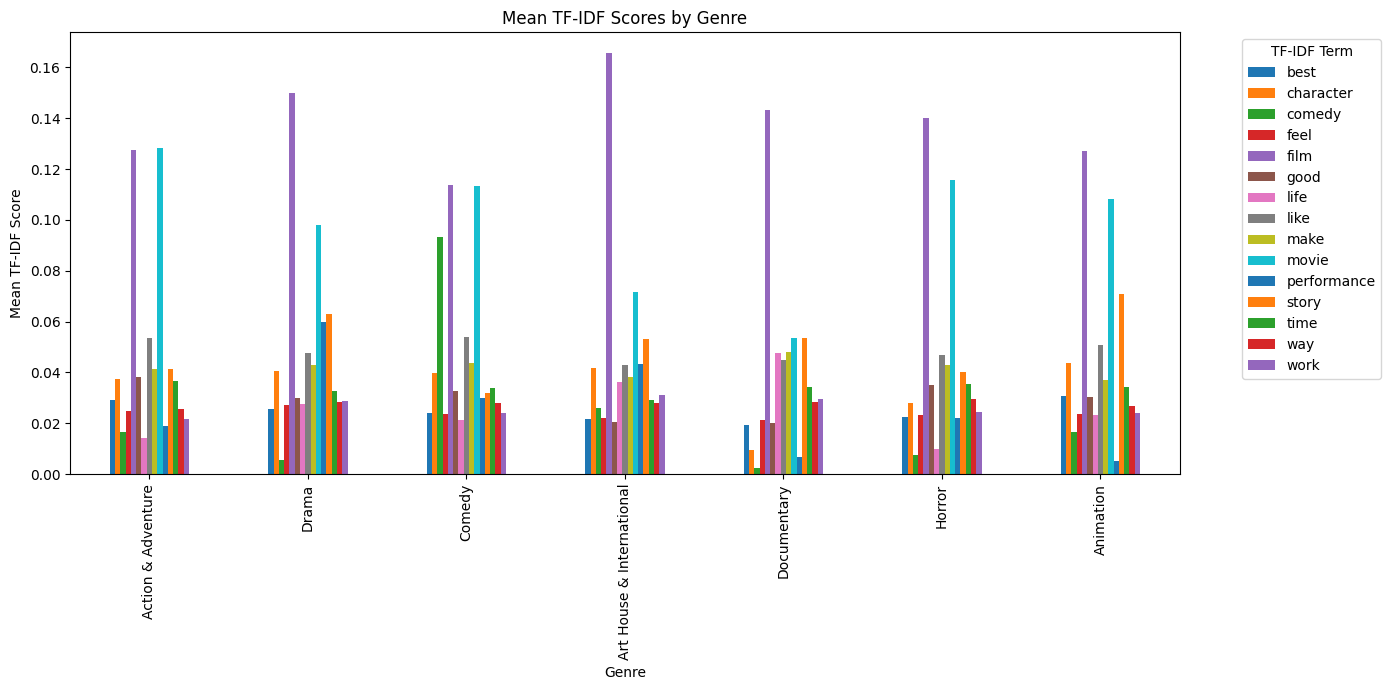

In [43]:
# Get all unique genres
unique_genres = df['genre'].unique()

# Compute mean TF-IDF score per genre
mean_tfidf_by_genre = {}
for genre in unique_genres:
    genre_texts = df[df['genre'] == genre]['normalized_review']
    if not genre_texts.empty:
        tfidf_matrix = vectorizer.transform(genre_texts)
        mean_tfidf = np.mean(tfidf_matrix.toarray(), axis=0)
        mean_tfidf_by_genre[genre] = mean_tfidf

# Create DataFrame: rows = genres, columns = terms
tfidf_genre_df = pd.DataFrame(mean_tfidf_by_genre, index=features).T

# Show only top genres by row count for plotting
top_genres = df['genre'].value_counts().head(7).index.tolist()
tfidf_plot_df = tfidf_genre_df.loc[top_genres]

# Plot
tfidf_plot_df.plot(kind='bar', figsize=(14, 7))
plt.title("Mean TF-IDF Scores by Genre")
plt.xlabel("Genre")
plt.ylabel("Mean TF-IDF Score")
plt.legend(title="TF-IDF Term", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Sentiment Analysis

#### Sentiment Analysis by Movie Genre

C:\Users\patri\AppData\Local\Temp\ipykernel_17816\1135214253.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='genre', data=genre_sentiment, palette='coolwarm')


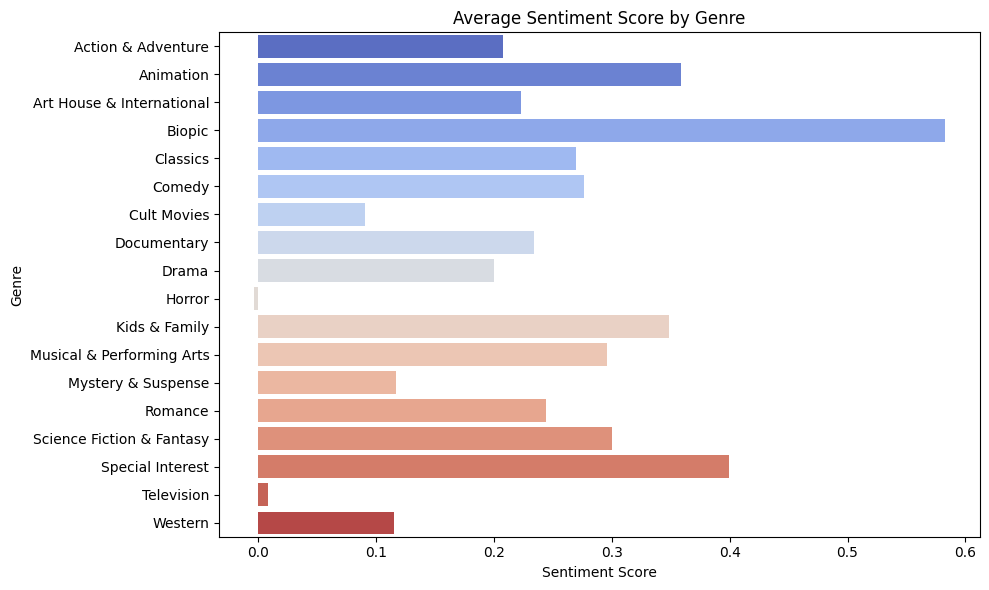

In [23]:
#Calculate average sentiment by movie genre
genre_sentiment = df.groupby('genre')['sentiment'].mean().reset_index()

#Plot average sentiment by movie genre
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment', y='genre', data=genre_sentiment, palette='coolwarm')
plt.title('Average Sentiment Score by Genre')
plt.xlabel('Sentiment Score')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

In [38]:
# Sort by sentiment in descending order (highest sentiment first)
g_ranked = genre_sentiment.sort_values(by='sentiment', ascending=False).reset_index(drop=True)
print(g_ranked)

                        genre  sentiment
0                      Biopic   0.583083
1            Special Interest   0.399494
2                   Animation   0.358397
3               Kids & Family   0.348889
4   Science Fiction & Fantasy   0.300160
5   Musical & Performing Arts   0.295714
6                      Comedy   0.276606
7                    Classics   0.269170
8                     Romance   0.243938
9                 Documentary   0.233523
10  Art House & International   0.222892
11         Action & Adventure   0.207776
12                      Drama   0.199751
13         Mystery & Suspense   0.116683
14                    Western   0.115255
15                Cult Movies   0.090276
16                 Television   0.008333
17                     Horror  -0.004077


#### Sentiment Analysis by Publication Type

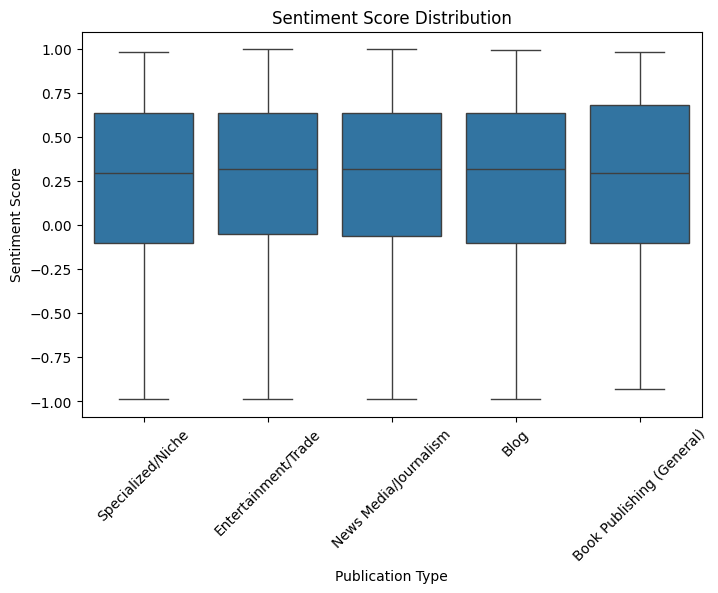

In [35]:
#Plot distribution of sentiment scores grouped by publication type
plt.figure(figsize=(8, 5))
sns.boxplot(x='publication_type', y='sentiment', data=df)
plt.title('Sentiment Score Distribution')
plt.xlabel('Publication Type')
plt.xticks(rotation=45)
plt.ylabel('Sentiment Score')
plt.show()

In [37]:
# List average sentiment score for each publication type, ranked highest to lowest
pub_sentiment = df.groupby('publication_type')['sentiment'].mean().reset_index()
p_ranked = pub_sentiment.sort_values(by='sentiment', ascending=False).reset_index(drop=True)
print(p_ranked)

            publication_type  sentiment
0  Book Publishing (General)   0.223641
1        Entertainment/Trade   0.223100
2      News Media/Journalism   0.218620
3                       Blog   0.216563
4          Specialized/Niche   0.210504


#### Sentiment Analysis by Movie

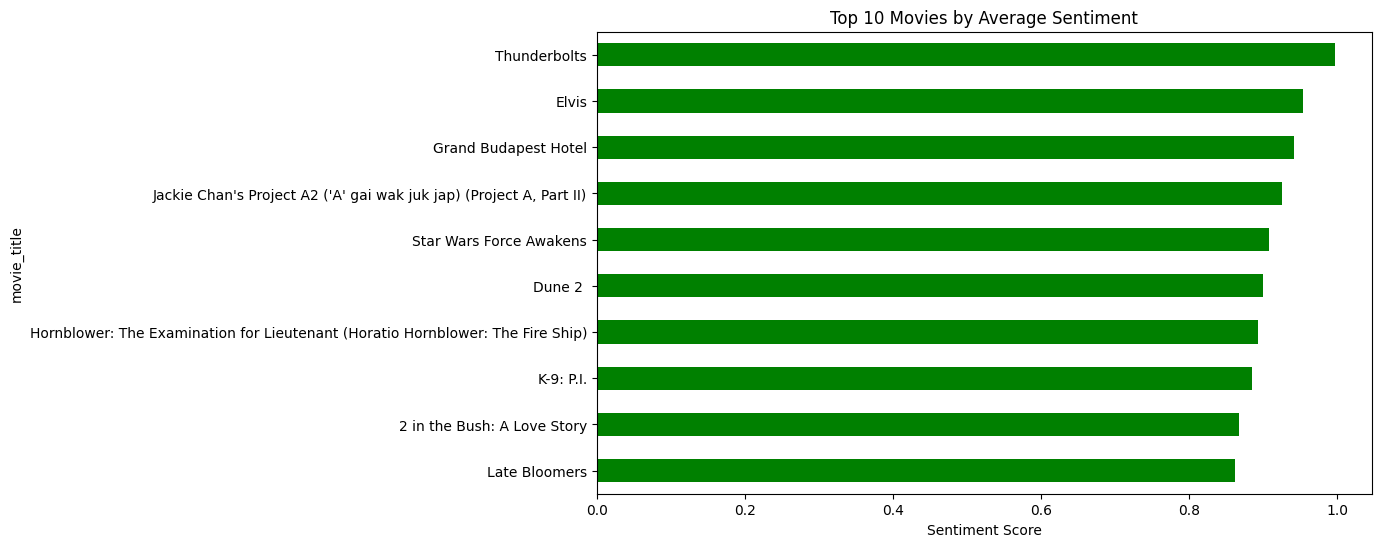

In [27]:
#For each movie calculate average review sentiment 
movie_sentiment = df.groupby('movie_title')['sentiment'].mean().sort_values(ascending=False)

#Plot top ten movies with highes average sentiment score
plt.figure(figsize=(10, 6))
movie_sentiment.head(10).plot(kind='barh', color='green')
plt.title('Top 10 Movies by Average Sentiment')
plt.xlabel('Sentiment Score')
plt.gca().invert_yaxis()
plt.show()

In [33]:
# Group by movie title and count reviews
top_movies_c = df['movie_title'].value_counts().head(10)

# Print top 10 movies and their counts
print("Top 10 Movies by Number of Reviews:")
print(top_movies_c)

Top 10 Movies by Number of Reviews:
movie_title
Star Wars: The Rise of Skywalker              972
Star Wars: The Last Jedi                      926
Solo: A Star Wars Story                       922
Rogue One: A Star Wars Story                  874
Star Wars: Episode VII - The Force Awakens    862
Spider-Man: Far From Home                     860
Robin Hood                                    850
Ready Player One                              844
Shazam!                                       786
Spider-Man: Homecoming                        760
Name: count, dtype: int64


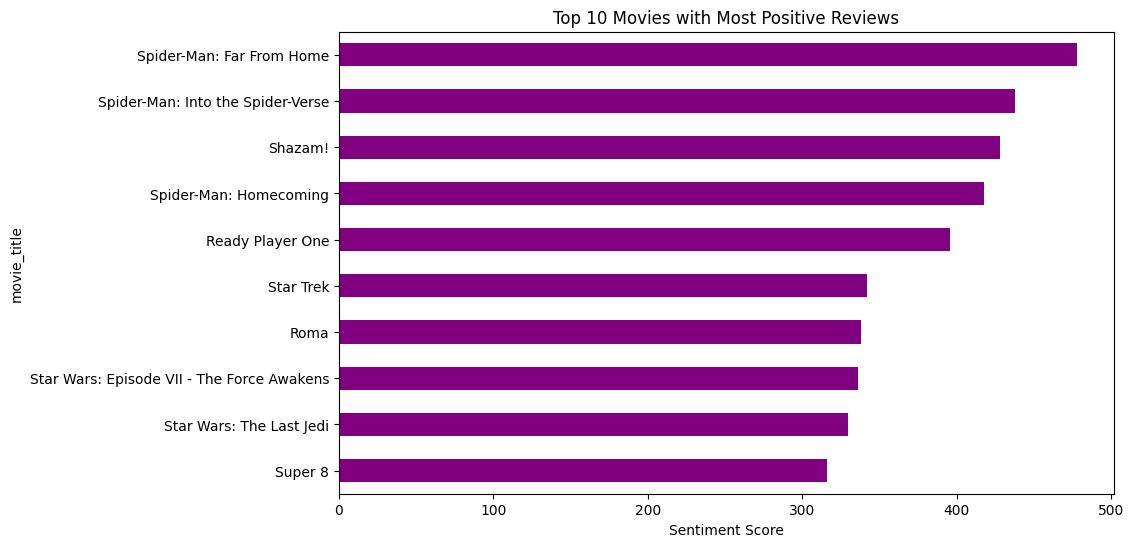

In [34]:
#new field for positive reviews
positive_reviews = df[df['sentiment'] > 0.6]

# Group by movie title and count of positive reviews
top_movies = positive_reviews['movie_title'].value_counts().head(10)

#plot top movies
plt.figure(figsize=(10, 6))
top_movies.head(10).plot(kind='barh', color='purple')
plt.title('Top 10 Movies with Most Positive Reviews')
plt.xlabel('Sentiment Score')
plt.gca().invert_yaxis()
plt.show()

### Word Cloud

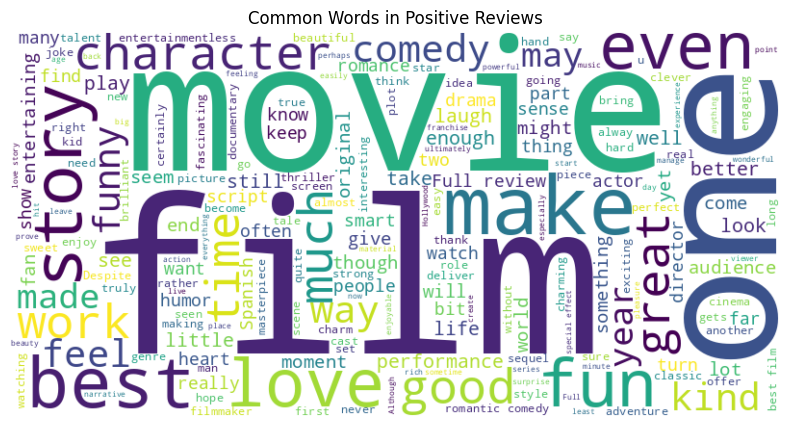

In [32]:
# Most positive reviews
positive_text = ' '.join(positive_reviews['review_text'].astype(str).values)

#create world cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

#plot word cloud 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Positive Reviews')
plt.show()
